## Training Binding Energy Models for -O and -OH

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.db import connect
import sys
import os

sys.path.append('../scripts')
from Slab import expand_triangle, Slab, inside_triangle
from FeatureReader import OntopStandard111, FccStandard111
from ase.db import connect
from ase.visualize import view

In [2]:
db_folder = "../DFT_data/"
features_folder = "../csv_features/DeltaE/"

## Setting reference energies

### Reaction 4: O adsorption

The chemical reaction:
$$ H_2O (l) + * \rightleftharpoons ^*O + 2(H^+ + e^-) $$

The equation for the binding energy:
$$ \Delta E = E_{^*O} - E_{H_2O (g)} - E_{*} + E_{H_2} -2eU $$
This includes the contribution from the potential, which we'll take care for later. Hence, we'll have the model predict just the non-voltage-dependant part:
$$ \Delta E = E_{^*O} - E_{H_2O (g)} - E_{*} + E_{H_2} $$

### Reaction 5: OH adsorption

The chemical reaction:
$$ H_2O (l) + * \rightleftharpoons ^*OH + (H^+ + e^-) $$

The equation for the binding energy:
$$ \Delta E = E_{^*OH} - E_{H_2O (g)} - E_{*} + \frac{1}{2} E_{H_2} -eU $$
This includes the contribution from the potential, which we'll take care for later. Hence, we'll have the model predict just the non-voltage-dependant part:
$$ \Delta E = E_{^*OH} - E_{H_2O (g)} - E_{*} + \frac{1}{2} E_{H_2} $$

In [3]:
# Free (eV)
CO2   = {"ZPE": 0.31, "CpdT": 0.10, "minusTS": -0.66, "TS": 0.66}
CO    = {"ZPE": 0.13, "CpdT": 0.09, "minusTS": -0.61, "TS": 0.61}
H2    = {"ZPE": 0.28, "CpdT": 0.09, "minusTS": -0.40, "TS": 0.40}
H2O   = {"ZPE": 0.57, "CpdT": 0.10, "minusTS": -0.67, "TS": 0.67}
HCOOH = {"ZPE": 0.90, "CpdT": 0.11, "minusTS": -0.99, "TS": 0.99}
#Slab = {"ZPE": 0.00, "CpdT": 0.00, "minusTS": -0.00} #Holy moly, den her overskrev Slab funktionen

# *Bound to the surface (eV)
# Bidentate *OOCH?
bound_CO   = {"ZPE": 0.19, "CpdT": 0.08, "minusTS": -0.16, "TS": 0.16}
bound_OH   = {"ZPE": 0.36, "CpdT": 0.05, "minusTS": -0.08, "TS": 0.08}
bound_OCHO = {"ZPE": 0.62, "CpdT": 0.11, "minusTS": -0.24, "TS": 0.24} #Either bidentate or monodentate. Use for both for now
bound_O    = {"ZPE": 0.07, "CpdT": 0.03, "minusTS": -0.04, "TS": 0.04}
bound_COOH = {"ZPE": 0.62, "CpdT": 0.10, "minusTS": -0.19, "TS": 0.19}
bound_H    = {"ZPE": 0.23, "CpdT": 0.01, "minusTS": -0.01, "TS": 0.01}

# Approximation Factors (FA)
AF = {"CO2": CO2, "CO": CO, "H2": H2, "H2O": H2O, "HCOOH": HCOOH, \
      "bound_CO": bound_CO, "bound_OH": bound_OH, "bound_OCHO": bound_OCHO, \
      "bound_O": bound_O, "bound_COOH": bound_COOH, "bound_H": bound_H, \
      "Slab": Slab}

# This is from the molecules_out.db file
molecules_dict = {'CO': -12.848598765234707,\
 'CO2': -19.15168636258064,\
 'CH2O2': -25.7548327798152,\
 'C2H4O2': -41.95993780269195,\
 'H2': -6.67878491734772,\
 'H2O': -12.225511685485456,\
 'CH2O': -19.92286258910958,\
 'CH4O': -27.652189372849637,\
 'C2H6O': -43.67355392866396,\
 'C2H2O2': -32.92328015484662,\
 'C2H2O4': -44.117581976029946}

## O features

In [4]:
### Summing up all the Approximation Factors for O
ZpE_sum  = AF["bound_O"]["ZPE"]  - AF["H2O"]["ZPE"]  + AF["H2"]["ZPE"]
CpdT_sum = AF["bound_O"]["CpdT"] - AF["H2O"]["CpdT"] + AF["H2"]["CpdT"]
TS_sum   = AF["bound_O"]["TS"]   - AF["H2O"]["TS"]   + AF["H2"]["TS"]
correction_constant_O = ZpE_sum + CpdT_sum - TS_sum
# Add extra correction constant here
# 

In [5]:
def correct_DFT_energy_O(correction_constant, molecules_dict, E_O, E_slab):
    DeltaE = E_O - molecules_dict["H2O"] + molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    #return DeltaG
    return DeltaE

## OH features

In [6]:
### Summing up all the Approximation Factors for OH
ZpE_sum  = AF["bound_OH"]["ZPE"]  - AF["H2O"]["ZPE"]  + 1/2*AF["H2"]["ZPE"]
CpdT_sum = AF["bound_OH"]["CpdT"] - AF["H2O"]["CpdT"] + 1/2*AF["H2"]["CpdT"]
TS_sum   = AF["bound_OH"]["TS"]   - AF["H2O"]["TS"]   + 1/2*AF["H2"]["TS"]
correction_constant_OH = ZpE_sum + CpdT_sum - TS_sum

In [7]:
def correct_DFT_energy_OH(correction_constant, molecules_dict, E_OH, E_slab):
    DeltaE = E_OH - molecules_dict["H2O"] + 1/2*molecules_dict["H2"] - E_slab
    DeltaG = DeltaE + correction_constant
    #return DeltaG
    return DeltaE

### Make the feature vectors and save .csv files

In [10]:
# Specify metals
metals = ['Ag', 'Au', 'Cu', 'Pd', 'Pt']
alloy = ''.join(metals)

# Specify name of databases
db_name_O = 'O_out.db'
db_name_OH = 'OH_out.db'
db_name_slab = "slabs_out_OH_O.db"

# Initiate feature readers
reader_O = FccStandard111(metals)
reader_OH = OntopStandard111(metals)

site_ids_O = [16, 17, 18]

# Initiate counters of rejected samples
rejected_O = 0
rejected_OH = 0

# Writer headers to files
with open(f'{features_folder}O_features.csv', 'w') as file_O:
    column_names = [f"feature{n}" for n in range(55)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_O}row')
    file_O.write(",".join(column_names))
    
# Writer headers to files
with open(f'{features_folder}OH_features.csv', 'w') as file_OH:
    column_names = [f"feature{n}" for n in range(20)]
    column_names.append('G_ads (eV)')
    column_names.append('slab db row')
    column_names.append(f'{db_name_O}row')
    file_OH.write(",".join(column_names))
    
# Load HEA(111) databases
with connect(f'{db_folder}{db_name_O}') as db_O,\
     connect(f'{db_folder}{db_name_OH}') as db_OH,\
     connect(f'{db_folder}{db_name_slab}') as db_slab,\
     open(f'{features_folder}O_features.csv', 'a') as file_O,\
     open(f'{features_folder}OH_features.csv', 'a') as file_OH:
    #print("A1")
    # Iterate through slabs without adsorbates
    for row_slab in db_slab.select('energy', H=0, C=0, O=0): # This doesn't even trigger lmao
        #print("A2")
        # Iterate through the two adsorbates
        for ads in ['OH', 'O']:
            #print("A3")
            # Set adsorbate-specific parameters
            if ads == 'OH':
                db = db_OH
                kw = {'O': 1, 'H': 1}
                db_name = db_name_OH
                out_file = file_OH

            elif ads == 'O':
                db = db_O
                kw = {'O': 1, 'H': 0}
                db_name = db_name_O
                out_file = file_O

            # Set counter of matched slabs between the databases to zero
            n_matched = 0

            # Get the corresponding slab with adsorbate
            for row in db.select('energy', **kw, **row_slab.count_atoms()):
                #print("A4")
                # If symbols match up
                if row.symbols[:-len(ads)] == row_slab.symbols:
                    #print("A5")
                    # Increment the counter of matched structures
                    n_matched += 1

                    # Get atoms object
                    atoms = db.get_atoms(row.id)

                    # Make slab instance
                    slab = Slab(atoms, ads=ads, ads_atom='O')

                    # If the adsorbate is *OH
                    if ads == 'OH':

                        # Get adsorption site elements as neighbors within a radius
                        site_elems, site = slab.get_adsorption_site(radius=2.6, hollow_radius=2.6)

                        # If the site does not consist of exactly one atom, then skip this sample
                        # as the *OH has moved too far away from an on-top site
                        try:
                            if len(site_elems) !=1:
                                rejected_OH += 1
                                #slab.view()
                                continue
                        except TypeError:
                            print(site_elems, site)
                            print(row_slab.id, row.id)
                            slab.view()
                            exit()

                        # Get features of structure
                        features = reader_OH.get_features(slab, radius=2.6)
                        
                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_OH(correction_constant_OH, molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

                    # Else, if the adsorbate is O*
                    elif ads == 'O':

                        # Get hollow site planar corner coordinates
                        site_atoms_pos_orig = atoms.positions[site_ids_O, :2]

                        # Get expanded triangle vertices
                        site_atoms_pos = expand_triangle(site_atoms_pos_orig, expansion=1.45)

                        # Get position of adsorbate atom (with atom index XXX 20 XXX)
                        ads_pos = atoms.positions[20][:2]

                        # If the oxygen is outside the expanded fcc triangle,
                        # then it is most likely in an hcp site, that is not
                        # being modeled
                        if not inside_triangle(ads_pos, site_atoms_pos):
                            rejected_O += 1
                            continue

                        # Get features of structure
                        features = reader_O.get_features(slab, radius=2.6, site_ids=site_ids_O)

                        ### This part is now adsorbate-specific ###
                        # Get adsorption energy
                        E_ads = correct_DFT_energy_O(correction_constant_O, molecules_dict, row.energy, row_slab.energy) # This is the new formula

                        # Write output to file
                        features = ','.join(map(str, features))
                        out_file.write(f'\n{features},{E_ads:.6f},{row_slab.id},{row.id}')

            # Print a message if more than one slabs were matched. This probably means that
            # the same slab has accidentally been saved multiple to the database
            if n_matched > 1:
                print(f'[INFO] {n_matched} {ads} and slab matched for row {row_slab.id} in {db_name_slab}')

            # Print a message if no slabs were matched. This probably means that the DFT calculation
            # did not converge and was left out
            #elif n_matched == 0:
                #print(f'[INFO] No match found in {db_name} for row {row_slab.id} in {db_name_slab}')

# Print the number of rejected samples to screen
print('rejected OH samples: ', rejected_OH)
print('rejected O samples: ', rejected_O)

rejected OH samples:  20
rejected O samples:  1


## Train binding energy models for OH and O

In [3]:
import warnings
warnings.filterwarnings('ignore')

import xgboost;
from xgboost import XGBRegressor;
import pandas as pd;
from sklearn.model_selection import train_test_split;
from xgboost import plot_importance;
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

import random
random.seed(1)
np.random.seed(1)

import time

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
import matplotlib.ticker as ticker

from functions import prepare_dataset, learning_curve, train_XGB_model, features_from_mixed_sites, single_parity_plot

figure_folder = "../figures/DeltaG_models/DeltaE/"

### Load OH data

In [5]:
feature_folder = "../csv_features/DeltaE/"
filename = "OH_features.csv"

#OH_df = prepare_csv(feature_folder, , 2) #H kalder vi 0
OH_df = pd.read_csv(feature_folder + filename)
full_df = pd.concat([OH_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

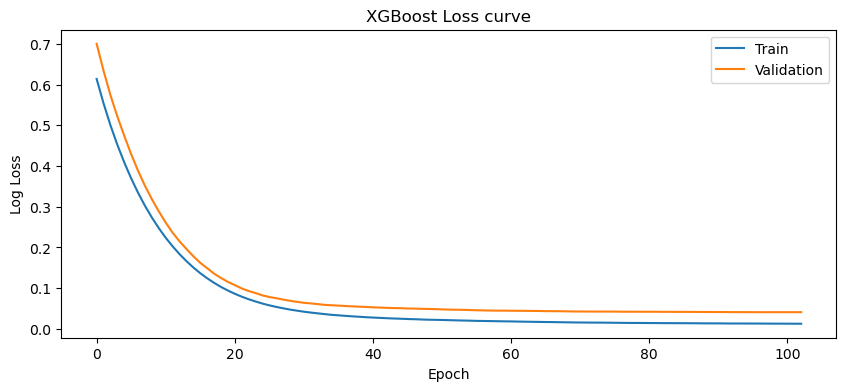

Training score:  0.9969139007165018
Validation score:  0.9692515019903445


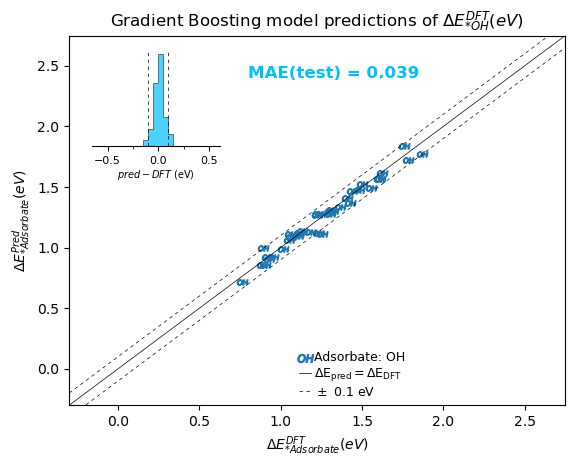

In [11]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_OH =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_OH.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_OH.save_model("../models/DeltaE/"+"OH_HEA.model")

learning_curve(XGBModel_OH, "OH_HEA")

score = XGBModel_OH.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_OH.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_OH, "OH_HEA", X_test, y_test, "OH", "OH") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

### Load O data

In [4]:
feature_folder = "../csv_features/"
filename = "O_features.csv"

O_df = pd.read_csv(feature_folder + filename)

full_df = pd.concat([O_df], axis = 0)
all_cols = full_df.columns
#Seperate the energies and remove the useless columns

X = full_df.loc[:, :all_cols[-4]]
y = full_df[["G_ads (eV)"]]

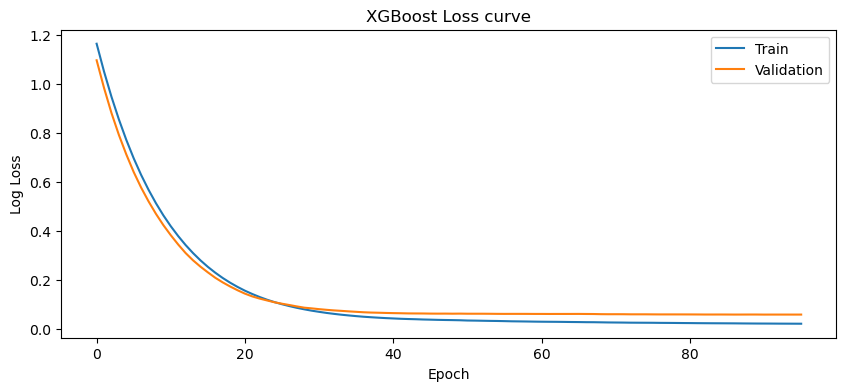

Training score:  0.9950940003087321
Validation score:  0.9568331600179691


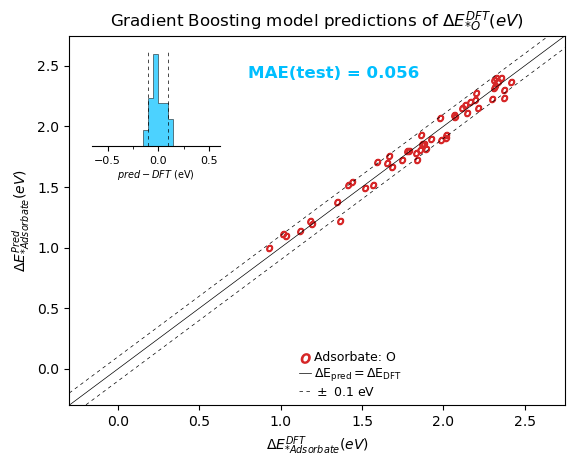

In [7]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_O =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_O.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_O.save_model("../models/DeltaE/"+"O_HEA.model")

learning_curve(XGBModel_O, "O_HEA")

score = XGBModel_O.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_O.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_O, "O_HEA", X_test, y_test, "O", "O") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")

In [143]:
# Note: Maybe I should show an average MAE over 10 shuffles of the dataset? Not that important to the main aim of the project though. 

## Mix model: *COOH + *H - This is now done in Training_E_models.ipynb


Feature vector: [H_feature0, H_feature1, ..., COOH_feature0, COOH_feature1]

In [144]:
# Loading two different .csv files, combining them properly and training a model on them. 

In [152]:
feature_folder = "../csv_features/"
filename_H = "COOH_H_Hvec_features.csv"
filename_COOH = "COOH_H_COOHvec_features.csv"

# Read the dataframes
H_df = pd.read_csv(feature_folder + filename_H)
COOH_df = pd.read_csv(feature_folder + filename_COOH)

# Combine the dataframes
combined_df = pd.merge(H_df, COOH_df, on="COOH_H_adsorbed_all_sites_out.dbrow")
y = combined_df[["G_ads (eV)"]] #Do I need to hardcopy this in order to not pass by reference?

# List of unwanted column names
unwanted_columns = ['G_ads(eV)', 'slab db row_x', 'COOH_H_adsorbed_all_sites_out.dbrow', 'G_ads (eV)', 'slab db row_y']

# Remove the unwanted columns from the combined dataframe
X = combined_df.drop(columns=unwanted_columns)

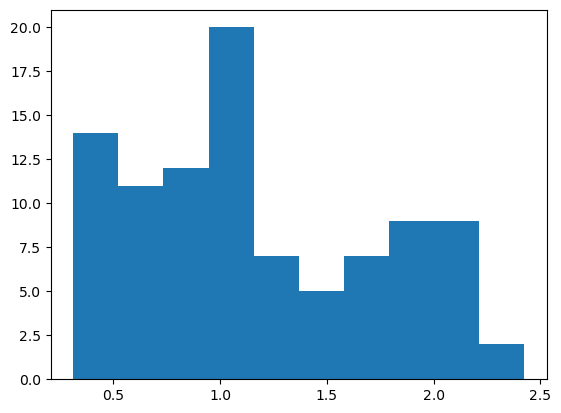

In [155]:
plt.hist(y)
plt.show()

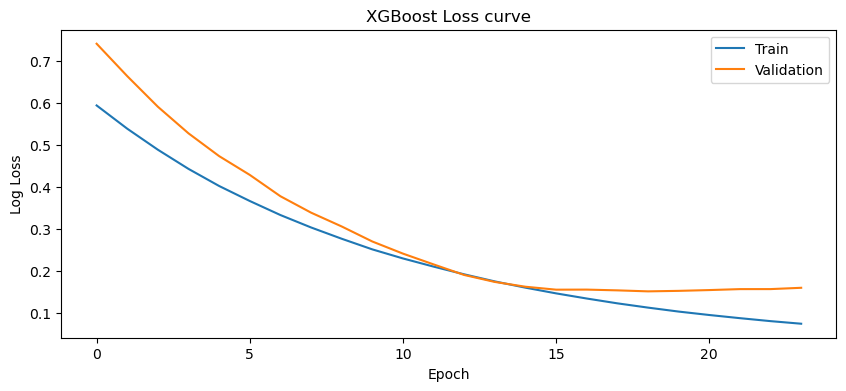

Training score:  0.9195230074581362
Validation score:  0.8031822055037112


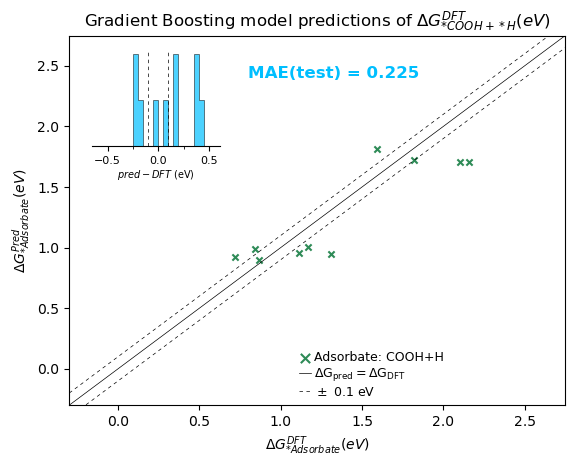

In [123]:
# Prepare data for XGBoost

#shuffle and split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5)

# Prepare XGBoost 
eval_set = [(X_train, y_train), (X_val, y_val)]
XGBModel_COOH_H =  XGBRegressor(learning_rate = 0.1 #learning rate
                                , max_depth = 5     #maximum tree depth
                                , n_estimators = 500 #number of boosting rounds
                                , n_jobs = 8 #number of threads
                                , use_label_encoder = False)

XGBModel_COOH_H.fit(X_train, y_train
                       , eval_set = eval_set
                       , early_stopping_rounds = 5
                       , eval_metric = ["mae"]
                       , verbose = False) #evals

# Save model in the /models folder
XGBModel_COOH_H.save_model("../models/"+"COOH_H.model")

learning_curve(XGBModel_COOH_H)

score = XGBModel_COOH_H.score(X_train, y_train) #Det må man ikke før den er blevet trænet
print("Training score: ", score)

score = XGBModel_COOH_H.score(X_val, y_val) #Det må man ikke før den er blevet trænet
print("Validation score: ", score)

single_parity_plot(XGBModel_COOH_H, X_test, y_test, "COOH+H", "COOH+H") ## Maybe I should make a new line with MAE_avg
#single_parity_plot(XGBModel_H_Pro, X_test, y_test, "H", "H")